In [27]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

#We are going to do time series analysis and forecasting for stock market.

In [70]:
#df1 = pd.read_csv('Apple.csv')
df1 = pd.read_csv('C:\\Users\\admin\\Desktop\\AAPL_data.csv')
#df2= pd.read_csv('amazon.csv')
stock=df1

In [36]:
stock.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
2,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
3,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
4,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [38]:
stock['date'].min()

'2013-02-08'

In [39]:
stock['date'].max()

'2018-02-07'

In [40]:
#stock['Date']=pd.to_datetime(df.Date,format='%Y%m%d', errors='ignore')

In [48]:
stock.date = pd.to_datetime(stock.date, format='%Y%m%d', errors='ignore')


## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [45]:
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
stock.drop(cols, axis=1, inplace=True)
stock = stock.sort_values('Date')

KeyError: "['high' 'low' 'open' 'volume' 'Name'] not found in axis"

In [49]:
stock.isnull().sum()

date     0
close    0
dtype: int64

In [50]:
stock = stock.groupby('date')['close'].sum().reset_index()

In [52]:
stock.head()

,date,close
0,2013-02-08,67.8542
1,2013-02-11,68.5614
2,2013-02-12,66.8428
3,2013-02-13,66.7156
4,2013-02-14,66.6556


## Indexing with time series data

In [54]:
stock = stock.set_index('date')
stock.index

Index(['2013-02-08', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14',
       '2013-02-15', '2013-02-19', '2013-02-20', '2013-02-21', '2013-02-22',
       ...
       '2018-01-25', '2018-01-26', '2018-01-29', '2018-01-30', '2018-01-31',
       '2018-02-01', '2018-02-02', '2018-02-05', '2018-02-06', '2018-02-07'],
      dtype='object', name='date', length=1259)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [56]:
#y = stock['Close'].resample('M').mean()
stock.index = pd.to_datetime(stock.index)

monthly_mean = stock.close.resample('M').mean()


Have a quick peek 2017 sales data.

In [57]:
monthly_mean['2018':]

date
2018-01-31    174.005238
2018-02-28    161.468000
Freq: M, Name: close, dtype: float64

## Visualizing Close time series data

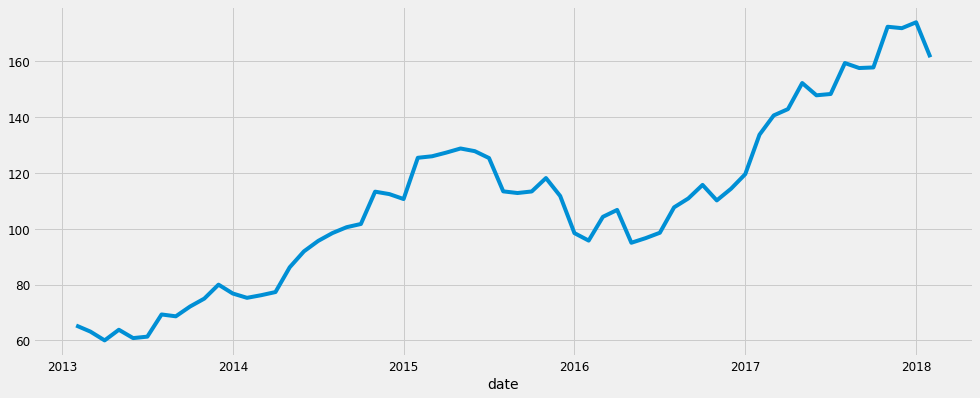

In [58]:
monthly_mean.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

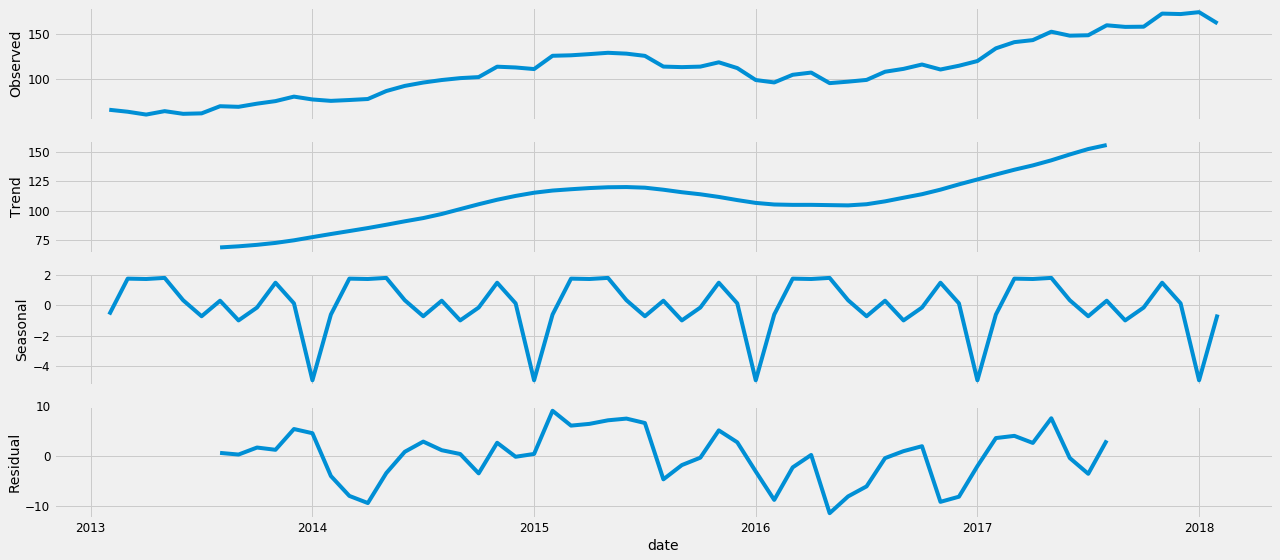

In [59]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the Close price is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model. ARIMA models are denoted with the notation `ARIMA(p, d, q)`. These three parameters account for seasonality, trend, and noise in data:`

In [60]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [61]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:741.0290817777002
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:571.1352438355207
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.930189822054
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:361.73608351421115
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:471.0378184172823
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:434.7803564242059
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:372.2241107149493
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:362.01554000375677
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:655.2023147150264
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:501.53732801018003
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:416.70598910762476
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:311.3967963940604
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:423.26006121990974
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:383.8742491158328
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:333.456319926981
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:312.82538249416996
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:386.40094260440105
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:314.26818819470446
ARIM

In [62]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

In [63]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9694      0.039     24.653      0.000       0.892       1.046
ma.L1          0.0999      0.262      0.381      0.704      -0.415       0.614
ma.S.L12      -1.0000   8578.620     -0.000      1.000   -1.68e+04    1.68e+04
sigma2        45.7190   3.92e+05      0.000      1.000   -7.69e+05    7.69e+05


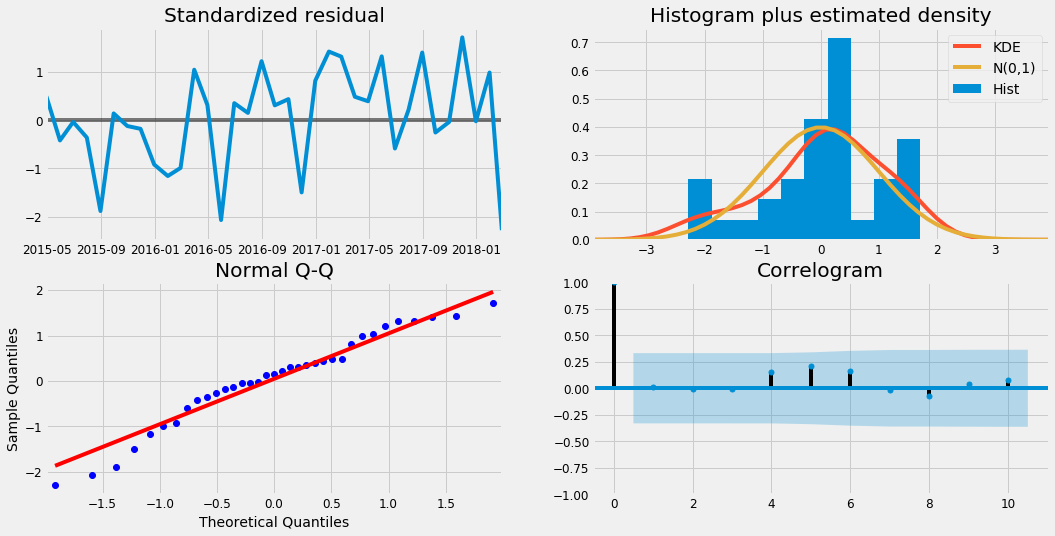

In [64]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted Close to real close price of the time series, and we set forecasts to start at `2017-12-31` to the end of the data.

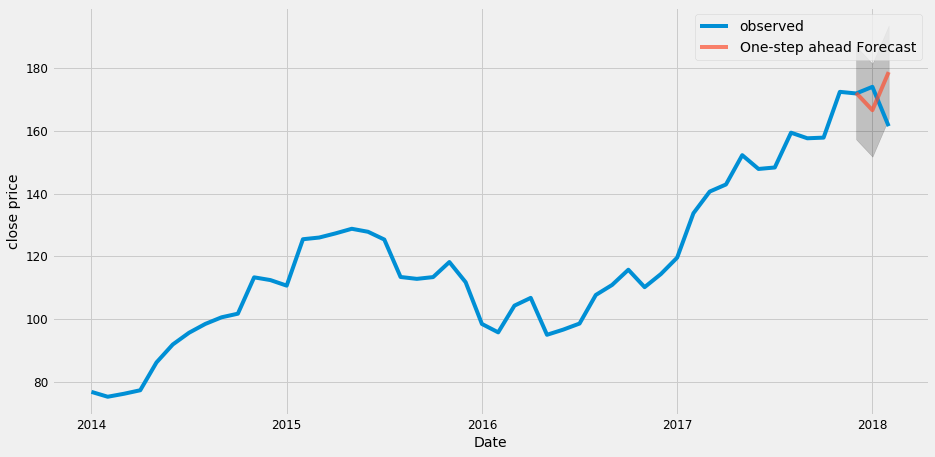

In [65]:
pred = results.get_prediction(start=pd.to_datetime('2017-12-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = monthly_mean['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [66]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2017-12-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 117.47


In [67]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 10.84


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily close price in the test set within portion... of the real close price.

## Producing and visualizing forecasts

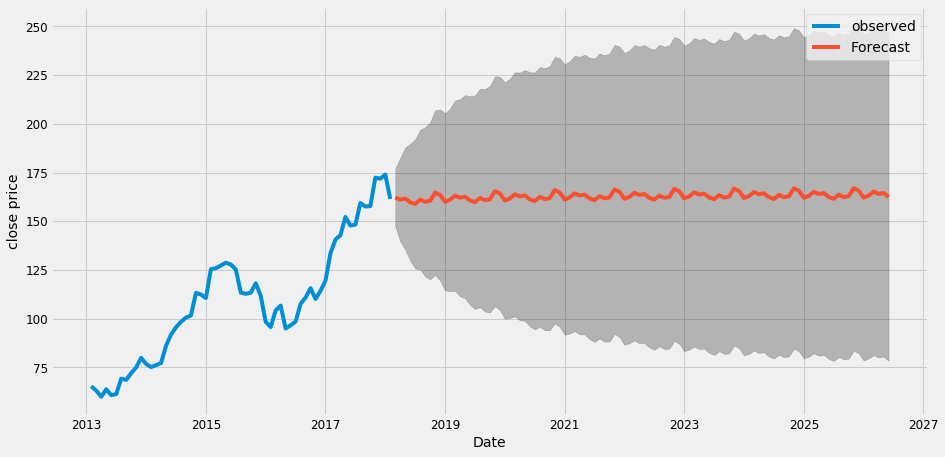

In [68]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.legend()
plt.show()

Our model clearly captured close price seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.